# gpCAM Advanced Application
In this notebook, we will go through many features of gpCAM. Work through it 
and you are ready for your own autonomous experiment.

In [1]:
####install gpcam here if you do not have already done so
#!pip install gpcam==8.1.13

## Preparations

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import plotly.graph_objects as go
import numpy as np
def plot(x,y,z,data = None):
    fig = go.Figure()
    fig.add_trace(go.Surface(x = x, y = y,z=z))
    if data is not None: 
        fig.add_trace(go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2],
                                   mode='markers'))

    fig.update_layout(title='Posterior Mean', autosize=True,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))


    fig.show()

## Defining Prediction Points 

In [4]:
x_pred = np.zeros((10000,2))
x = np.linspace(0,10,100)
y = np.linspace(0,10,100)
x,y = np.meshgrid(x,y)
counter = 0
for i in  range(100):
    for j in range(100):
        x_pred[counter] = np.array([x[i,j],y[i,j]])
        counter += 1

## Definition of Optional Customization Functions

In [5]:
def optional_acq_func(x,obj):
    #this acquisition function makes the autonomous experiment a Bayesian optimization
    #but is just here as an example. 'acq_funciton="ucb"' will give you the same result
    a = 3.0 #3.0 for 95 percent confidence interval
    mean = obj.posterior_mean(x)["f(x)"]
    cov = obj.posterior_covariance(x)["v(x)"]
    return mean + a * np.sqrt(cov)

def optional_mean_func(x,hyperparameters):
    #the prior mean function should return a vector: a mean function evaluation for every x
    return np.zeros((len(x)))

def optional_cost_function(origin,x,arguments = None):
    #cost pf l1 motion in the input space
    offset = arguments["offset"]
    slope = arguments["slope"]
    d = np.abs(np.subtract(origin,x))
    c = (d * slope) + offset
    n = np.sum(c)
    return n

def optional_cost_update_function(costs, parameters):
    ###defining a cost update function might look tricky but just needs a bit
    ###of tenacity. And remember, this is optional, if you have a great guess for your costs you
    ###don't need to update the costs. Also, if you don't account for costs, this function is not needed.
    #In this example we just return the old parameters, but print the costs. 
    #I hope it is clear how the parameters can be fitted to the recorded costs.
    print("recorded costs (from,to,costs): ", costs)
    
    return parameters

## AutonomousExperimenter Initialization

In [6]:
import time
from gpcam import AutonomousExperimenterGP

def instrument(data):
    print("Suggested by gpCAM: ")
    for entry in data:
        print("suggested:", entry["x_data"])
        entry["y_data"] = np.sin(np.linalg.norm(entry["x_data"]))
        entry["noise variance"] = 0.1
        entry["cost"]  = [np.array([0,0]),entry["x_data"],np.sum(entry["x_data"])]
        print("received: ", entry["y_data"])
    print("")
    return data

#initialization
#feel free to try different acquisition functions, e.g. optional_acq_func, "covariance",
#note how costs are defined for the autonomous experimenter
my_ae = AutonomousExperimenterGP(np.array([[0,10],[0,10]]),
                                 np.ones((3)), np.array([[0.001,100.],[0.001,100.],[0.001,100.]]),
                                 init_dataset_size= 20, instrument_function = instrument,
                                 acquisition_function = optional_acq_func, 
                                 cost_function = optional_cost_function, 
                                 cost_update_function = optional_cost_update_function,
                                 cost_function_parameters={"offset": 5.0, "slope":10.0},
                                 kernel_function = None, calc_inv = False,
                                 prior_mean_function = optional_mean_func,
                                 communicate_full_dataset = False, ram_economy = True)#, info = False, prior_mean_func = optional_mean_func)


print("length of the dataset: ",len(my_ae.x_data))


#my_ae.train_async()                 #train asynchronously
my_ae.train(method = "global")       #or not, or both, choose between "global","local" and "hgdl"

Suggested by gpCAM: 
suggested: [3.53571845 0.84318141]
received:  -0.4735126391133567
suggested: [3.8657577  4.59689863]
received:  -0.27336732959933824
suggested: [2.92930973 1.59924085]
received:  -0.1945861478810186
suggested: [6.71364205 0.09677935]
received:  0.4179197070833923
suggested: [0.89261026 4.13089175]
received:  -0.884134015021972
suggested: [5.52616195 8.26105505]
received:  -0.4918478102437928
suggested: [6.04056227 8.20436523]
received:  -0.6914184619240314
suggested: [2.28918366 6.00692107]
received:  0.144638369417519
suggested: [6.13806673 9.35688571]
received:  -0.9810630729198243
suggested: [3.59886888 5.44065213]
received:  0.2377477625016537
suggested: [2.20792889 5.22273948]
received:  -0.5752548495251131
suggested: [1.97677812 3.77664077]
received:  -0.900585194285055
suggested: [3.70224281 8.52258071]
received:  0.13240310541181305
suggested: [4.69625286 4.69002249]
received:  0.3465729071942172
suggested: [0.12674113 9.58301284]
received:  -0.158402933997

In [7]:
#update hyperparameters in case they are optimized asynchronously
my_ae.update_hps()
print(my_ae.gp_optimizer.hyperparameters)

[ 0.53305631  1.         16.07658318]


In [8]:
#training and client can be killed if desired and in case they are optimized asynchronously
my_ae.kill_training()

## Initial Model Vizualization

In [9]:
f = my_ae.gp_optimizer.posterior_mean(x_pred)["f(x)"]
f_re = f.reshape(100,100)

plot(x,y,f_re, data = np.column_stack([my_ae.x_data,my_ae.y_data]))

## The go() Command

In [ ]:
#run the autonomous loop
my_ae.go(N = 100, 
            retrain_async_at=[30,40,50,60,70,80,90],
            retrain_globally_at = [20,22,24,26,28,30,40,50,60,70],
            retrain_locally_at = [21,22,56],
            acq_func_opt_setting = lambda obj: "global" if len(obj.data.dataset) % 2 == 0 else "local",
            update_cost_func_at = (50,),
            training_opt_max_iter = 20,
            training_opt_pop_size = 10,
            training_opt_tol      = 1e-6,
            acq_func_opt_max_iter = 20,
            acq_func_opt_pop_size = 20,
            acq_func_opt_tol      = 1e-6,
            number_of_suggested_measurements = 1,
            acq_func_opt_tol_adjust = 0.1)

## Visualization of the Resulting Model

In [11]:
#print(my_ae.gp_optimizer.x_data)



res = my_ae.gp_optimizer.posterior_mean(x_pred)
f = res["f(x)"]
f = f.reshape(100,100)

plot(x,y,f, data = np.column_stack([my_ae.gp_optimizer.gp.x_data,my_ae.gp_optimizer.gp.y_data]))

# Running a Multi-Task GP Autonomous Data Acquisition
This example uses 21 (!) dim robot data and 7 tasks, which you can all use or pick a subset of them

In [ ]:
##prepare some data
import numpy as np
from scipy.interpolate import griddata
data = np.load("./data/sarcos.npy")
print(data.shape)
x = data[:,0:21]
y = data[:,21:23]

from gpcam import AutonomousExperimenterFvGP

def instrument(data):
    for entry in data:
        print("Suggested by gpCAM: ", entry["x_data"])
        y_data = griddata(x,y,entry["x_data"],method = "nearest", fill_value = 0)[0]
        entry["noise variances"] = np.array([0.01, 0.01])
        entry["y_data"] = y_data
        print("received: ", entry["y_data"])
    print("")
    return data

def acq_func(x,obj):
    #multi-tast autonomous experiments should use a user-defined acquisition function to
    #take full advantage of the surrogate and the uncertainty in all tasks.
    a = 3.0 #3.0 for ~95 percent confidence interval
    mean = obj.posterior_mean(x, x_out = np.array([0,1]))["f(x)"]
    cov = obj.posterior_covariance(x, x_out = np.array([0,1]))["v(x)"]
    return np.linalg.norm(mean, axis = 1) + a * np.linalg.norm(cov,axis = 1)


input_space = np.array([np.array([np.min(x[:,i]),np.max(x[:,i])]) for i in range(len(x[0]))])
print("index set (input space) bounds:")
print(input_space)
print("hps bounds:")
hps_bounds = np.empty((23,2))
hps_bounds[:,0] = 0.0001
hps_bounds[:,1] = 100.0
hps_bounds[0] = np.array([0.0001, 10000])
print(hps_bounds)
print("shape of y: ")
print(y.shape)

my_fvae = AutonomousExperimenterFvGP(input_space,init_dataset_size= 10, instrument_function = instrument,
                                     acquisition_function=acq_func)

my_fvae.train()
my_fvae.go(N = 50, retrain_async_at=(22,), retrain_globally_at=(50,90,120), retrain_locally_at=(25,))

## Plotting the 0th task in a 2d slice

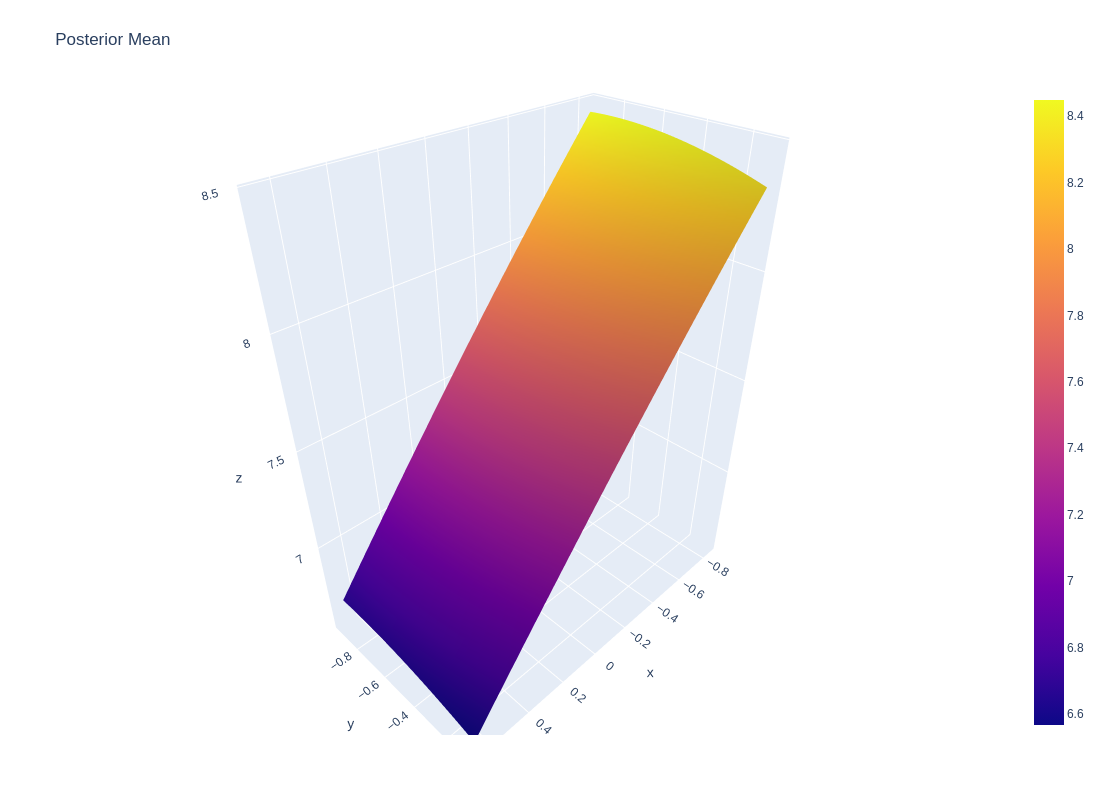

In [13]:
x_pred = np.zeros((10000,21))
x = np.linspace(input_space[0,0],input_space[0,1],100)
y = np.linspace(input_space[1,0],input_space[1,1],100)
x,y = np.meshgrid(x,y)
counter = 0
for i in  range(100):
    for j in range(100):
        x_pred[counter] = np.zeros((21))
        x_pred[counter,[0,1]] = np.array([x[i,j],y[i,j]])
        counter += 1
res = my_fvae.gp_optimizer.posterior_mean(x_pred, x_out = np.array([0.]))
f = res["f(x)"]
f = f.reshape(100,100)


plot(x,y,f)